In [1]:
from numpy import sin, cos, tan, sqrt, deg2rad, linspace, concatenate, meshgrid, roots, nanmin, nan, zeros, tile
import numpy as np

%matplotlib ipympl
# Nota instale ipympl con el comando de consola:
# conda install -c conda-forge ipympl
# una vez la instale, dele click al boton recargar de su explorador
# NOTA: este procedimiento solo toca realizarlo una vez, después de esto la librería quedará permanentemente instalada en su computador

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Se definen varias trigonométricas con los argumentos en grados, para hacer más legible el código:

In [2]:
sind = lambda x : sin(deg2rad(x))
cosd = lambda x : cos(deg2rad(x))
tand = lambda x : tan(deg2rad(x))
cotd = lambda x : 1/tan(deg2rad(x))

Se definen algunas constantes y parámetros del gráfico:

In [3]:
# Parámetros del gráfico
n = 8   # número de divisiones por plano
m = 2*n # número de divisiones de la componente hidrostática

A continuación definimos el modelo a graficar y sus parámetros:

In [4]:
# Se especifica el tipo de criterio de fluencia/falla a dibujar
#modelo = 'VON_MISES'
#modelo = 'TRESCA'
modelo = 'MOHR_COULOMB'
#modelo = 'DRUCKER_PRAGER'
#modelo = 'MATSUOKA_NAKAI'

# Parámetros del material dúctil (Von Mises, Tresca)
fy  =  5 # [MPa]      esfuerzo de fluencia

# Parámetros del material frágil (Mohr-Coulomb, Drucker-Prager, Matsuoka-Nakai)
c   =  2 # [MPa]      cohesión
phi = 20 # [grados]   ángulo de fricción

Se definen las funciones para calcular $\rho$ para cada superficie de falla:

In [5]:
def rho_von_mises(fy):
    rho = tile(sqrt(2/3)*fy, (m, 6*n-5))
    return rho

In [6]:
def rho_tresca(theta, fy):
    rho = sqrt(2)*fy/(2*sind(theta + 60))
    return rho

In [7]:
def rho_mohr_coulomb(theta, xi, c, phi):
    num = sqrt(2)*(c*cosd(phi) - (xi/sqrt(3))*sind(phi))
    den = sind(theta + 60) + sind(phi)*cosd(theta + 60)/sqrt(3)
    rho = num/den
    return rho

In [8]:
def rho_drucker_prager(theta, xi, c, phi, tipo):
    if tipo == 'vertices_mayores':
        # Pasando por vértices mayores
        A = 6*c*cosd(phi)/(sqrt(3)*(3-sind(phi)))
        B = 2*sind(phi)/(sqrt(3)*(3-sind(phi)))
    elif tipo == 'vertices_menores':               
        # Pasando por vértices menores
        A = 6*c*cosd(phi)/(sqrt(3)*(3+sind(phi)))
        B = 2*sind(phi)/(sqrt(3)*(3+sind(phi)))
    else:
        raise ValueError("Tipo debe ser 'vertices_mayores' o 'vertices_menores'")
        
    rho = sqrt(2)*A - sqrt(6)*B*xi
    return rho

In [9]:
def rho_matsuoka_nakai(theta, xi, c, phi):
    rho = zeros((m, 6*n-5))
    s0  = c*cotd(phi)
    kMN = (9 - sind(phi)**2)/(1 - sind(phi)**2)
    cos3theta = cosd(3*th_)
    for i in range(m):
        for j in range(6*n-5):
            if abs(cos3theta[j]) < 1e-9:
                rho[i,j] = sqrt((2*(kMN-9))/(3*(kMN-3)))*abs(xi[i,j]-sqrt(3)*s0)
            else:
                # Se calculan los coeficientes
                c0 =  sqrt(3)*(kMN - 9)*(xi[i,j] - sqrt(3)*s0)**3/9
                c2 = -sqrt(3)*(kMN - 3)*(xi[i,j] - sqrt(3)*s0)/6
                c3 =  sqrt(6)*kMN*cos3theta[j]/18
                
                # Se corrigen los errores de cálculo en los ceros
                if abs(c0) < 1e-9:
                    c0 = 0
                if abs(c2) < 1e-9:
                    c2 = 0
                sol = roots([c3, c2, 0, c0]) # raíces del polinomio

                # Como rho debe ser un número mayor o igual a cero, se 
                # desechan las raíces negativas
                sol = sol[sol >= 0]

                # Y de las raíces que quedan se escoge la menor
                rho[i,j] = nanmin(sol)
    return rho    

In [10]:
# Se calcula el ángulo de Lode (y se repite por la propiedad de simetría)
th  = linspace(0, 60, n)

# Esto es equivalente al comando de MATLAB:
#th_ = [ th th(end-1:-1:2) th th(end-1:-1:2) th th(end-1:-1:1) ];
th_ = concatenate([th, th[-2:-n:-1], th, th[-2:-n:-1], th, th[-2:-(n+1):-1]])

# Se calcula la componente hidrostática
if (modelo == 'VON_MISES'                  ) or \
   (modelo == 'TRESCA'                     ) or \
   (modelo == 'MOHR_COULOMB'   and phi == 0) or \
   (modelo == 'DRUCKER_PRAGER' and phi == 0):
    # En este caso cotd(phi) se vuelve infinito; 
    # si modelo == MOHR_COULOMB   con c=fy/2 y phi=0, se grafica TRESCA
    # si modelo == DRUCKER_PRAGER con c=fy/2 y phi=0, se grafica VON MISES
    xi_ = linspace(-10, 10, m)
else:
    xi_ = linspace(-10, sqrt(3)*c*cotd(phi), m)

# Se calculan theta y xi
theta, xi = meshgrid(th_, xi_)

In [11]:
# Se calcula el radio rho de la superficie de fluencia a graficar
match modelo:
    case 'VON_MISES':
        rho = rho_von_mises(fy)
    case 'TRESCA':
        rho = rho_tresca(theta, fy)
    case 'MOHR_COULOMB':
        rho = rho_mohr_coulomb(theta, xi, c, phi)
    case 'DRUCKER_PRAGER':            
        rho = rho_drucker_prager(theta, xi, c, phi, 'vertices_mayores')
    case 'MATSUOKA_NAKAI':    
        rho = rho_matsuoka_nakai(theta, xi, c, phi)
    case _:
        raise ValueError('Criterio desconocido')

In [12]:
# Se convierte la coordenada cilíndrica de HW a los esfuerzos principales
theta = linspace(0, 360, 6*n-5)  # 6*n-5 = length(th_)
s1 = xi/sqrt(3) + sqrt(2/3)*rho*cosd(theta)
s2 = xi/sqrt(3) + sqrt(2/3)*rho*cosd(theta - 120) # ecuaciones (*\eqref{eq:HW_to_s1s2s3}*)
s3 = xi/sqrt(3) + sqrt(2/3)*rho*cosd(theta + 120)

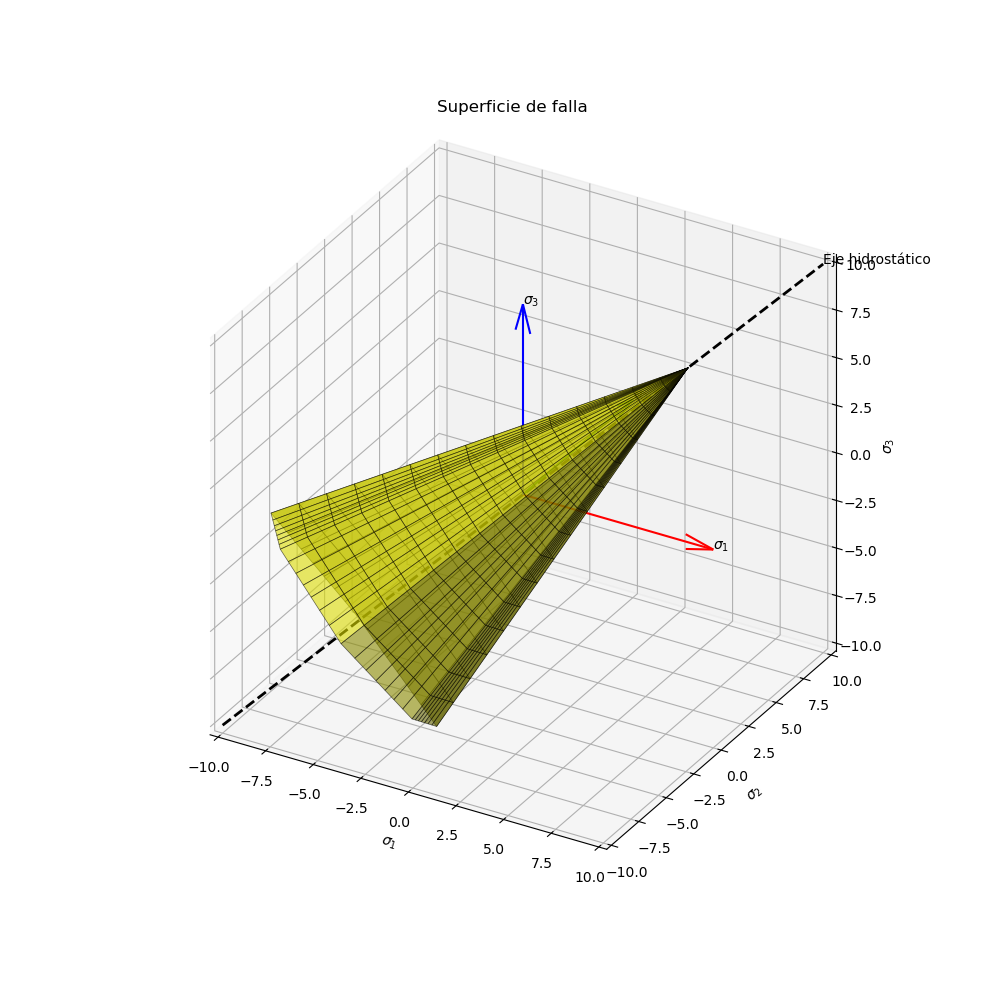

In [13]:
# Se crea la figura 3D
fig = plt.figure(" ", figsize=(10, 10))

# aquí "ortho" es para que no grafique en perspectiva, sino con proyección ortogonal, de modo que se pueda ver bien el plano meridiano
ax  = fig.add_subplot(111, projection='3d', proj_type='ortho')

# Se dibuja la superficie de fluencia
COLOR = 'yellow'
ax.plot_surface(s1, s2, s3, color=COLOR, alpha=0.6, edgecolor='k', linewidth=0.5)

# Se colocan los ejes
tamano_cabeza_flecha = 0.15  # Ajusta este valor para cambiar el tamaño de la cabeza de la flecha
ax.quiver(0, 0, 0, 10,  0,  0, color='r', arrow_length_ratio=tamano_cabeza_flecha)
ax.quiver(0, 0, 0,  0, 10,  0, color='g', arrow_length_ratio=tamano_cabeza_flecha)
ax.quiver(0, 0, 0,  0,  0, 10, color='b', arrow_length_ratio=tamano_cabeza_flecha)
ax.text(10,  0,  0, '$\sigma_1$')
ax.text( 0, 10,  0, '$\sigma_2$')
ax.text( 0,  0, 10, '$\sigma_3$')

# Se dibuja el eje hidrostático
ax.plot([-10, 10], [-10, 10], [-10, 10], 'k--', linewidth=2)
ax.text(10, 10, 10, 'Eje hidrostático', color='k')

# Se configura el gráfico
ax.set_aspect('equal')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('$\sigma_1$')
ax.set_ylabel('$\sigma_2$')
ax.set_zlabel('$\sigma_3$')
ax.set_title('Superficie de falla')
plt.show()